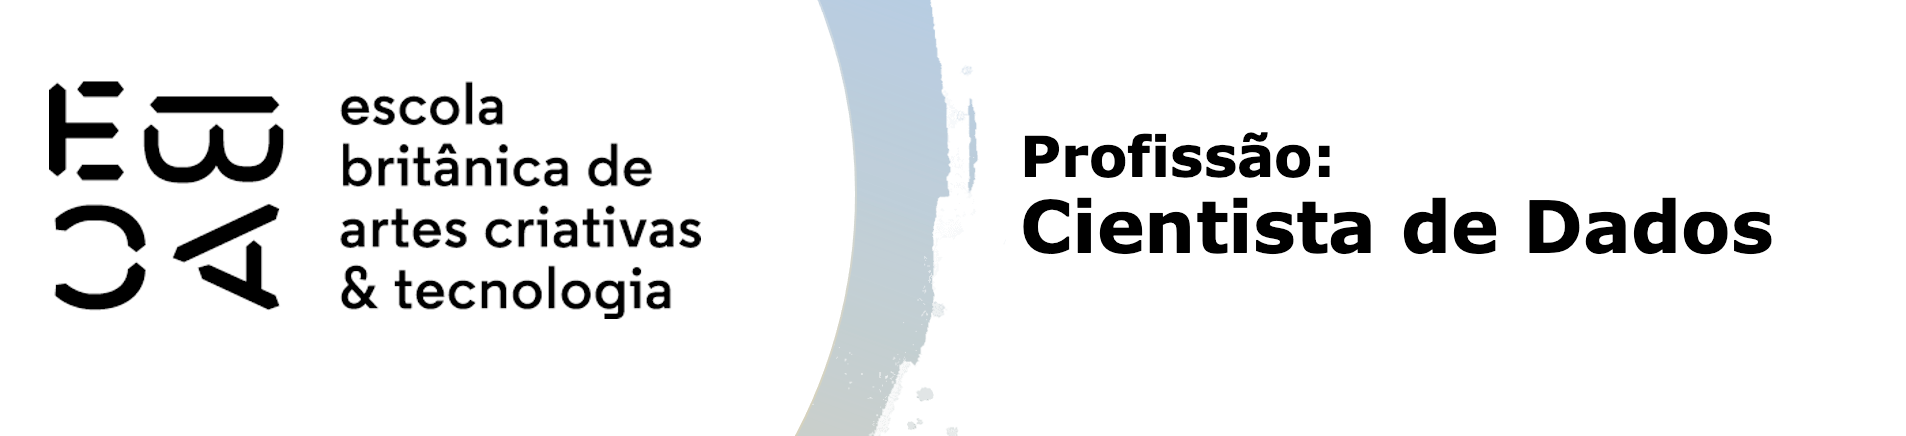

# Tarefa II - Módulo 36

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

## Pacotes + Dataframe

In [1]:
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import numpy             as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy                                import dmatrices

df = pd.read_pickle("base_nfp.pkl")
df.head()
df.dtypes

CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Semestre                        int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dtype: object

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [2]:
# Dia da semana + dummies + mes + trimestre
df['dia_semana'] = df['Data Emissão'].dt.dayofweek  # Segunda=0, Domingo=6
df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)  #1 para sábado/domingo, 0 caso contrário
df['dia_mes'] = df['Data Emissão'].dt.day
df['mes'] = df['Data Emissão'].dt.month
df['trimestre'] = df['Data Emissão'].dt.quarter

# Quantís
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], q=5, labels=False, duplicates='drop')
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], q=10, labels=False, duplicates='drop')
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')


# Conferindo
df.dtypes

CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Semestre                        int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dia_semana                      int32
fim_de_semana                   int32
dia_mes                         int32
mes                             int32
trimestre                       int32
valor_nf_q5                     int64
valor_nf_q10                    int64
valor_nf_q20                    int64
valor_nf_q50                    int64
dtype: object

In [3]:
# Conferindo a coluna para ver se é fim de semana ou não
df['fim_de_semana'].value_counts()

fim_de_semana
0    138502
1     49144
Name: count, dtype: int64

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [4]:
variaveis_vif = df.select_dtypes(include=['int64', 'float64','int32'])

variaveis_vif = variaveis_vif.dropna()


vif_data =pd.DataFrame()
vif_data['Variavel'] = variaveis_vif.columns
vif_data['Vif'] = [variance_inflation_factor(variaveis_vif.values, i) for i in range(variaveis_vif.shape[1])]

# 4. Ordenar do maior para o menor:
vif_data = vif_data.sort_values(by="Vif", ascending=False)

vif_data

,Variavel,Vif
14,valor_nf_q20,1771.752270
15,valor_nf_q50,1460.716537
13,valor_nf_q10,573.378618
11,trimestre,115.481324
12,valor_nf_q5,99.442784
10,mes,87.203913
3,Ano,24.132133
4,Semestre,15.140242
7,dia_semana,8.143356
9,dia_mes,4.287418


* Iremos fazer o teste agora somente com 1 variavel temporal.

In [5]:
############ VIF Ano

variaveis_vif = df.select_dtypes(include=['int64', 'float64','int32']).drop(columns=['Semestre','mes','Trimestre'], errors='ignore')

variaveis_vif = variaveis_vif.dropna()


vif_data =pd.DataFrame()
vif_data['Variavel'] = variaveis_vif.columns
vif_data['Vif'] = [variance_inflation_factor(variaveis_vif.values, i) for i in range(variaveis_vif.shape[1])]

# Ordernar
vif_data = vif_data.sort_values(by="Vif", ascending=False)

print('\nVif Somente Ano\n\n',vif_data)


########### VIF Semestre


variaveis_vif = df.select_dtypes(include=['int64', 'float64','int32']).drop(columns=['Ano','mes','Trimestre'], errors='ignore')

variaveis_vif = variaveis_vif.dropna()


vif_data =pd.DataFrame()
vif_data['Variavel'] = variaveis_vif.columns
vif_data['Vif'] = [variance_inflation_factor(variaveis_vif.values, i) for i in range(variaveis_vif.shape[1])]

# Ordernar
vif_data = vif_data.sort_values(by="Vif", ascending=False)

print('\n\nVif Somente Semestre\n\n',vif_data)

########### Trimestre

variaveis_vif = df.select_dtypes(include=['int64', 'float64','int32']).drop(columns=['Ano','mes','Semestre'], errors='ignore')

variaveis_vif = variaveis_vif.dropna()


vif_data =pd.DataFrame()
vif_data['Variavel'] = variaveis_vif.columns
vif_data['Vif'] = [variance_inflation_factor(variaveis_vif.values, i) for i in range(variaveis_vif.shape[1])]

# Ordernar
vif_data = vif_data.sort_values(by="Vif", ascending=False)

print('\n\nVif Somente Trimestre\n',vif_data)


########### Vif Mês

variaveis_vif = df.select_dtypes(include=['int64', 'float64','int32']).drop(columns=['Ano','Trimestre','Semestre'], errors='ignore')

variaveis_vif = variaveis_vif.dropna()


vif_data =pd.DataFrame()
vif_data['Variavel'] = variaveis_vif.columns
vif_data['Vif'] = [variance_inflation_factor(variaveis_vif.values, i) for i in range(variaveis_vif.shape[1])]

# Ordernar
vif_data = vif_data.sort_values(by="Vif", ascending=False)

print('\n\nVif Somente Mês\n',vif_data)


Vif Somente Ano

          Variavel          Vif
12   valor_nf_q20  1771.253261
13   valor_nf_q50  1460.511638
11   valor_nf_q10   573.295439
10    valor_nf_q5    99.434570
3             Ano    18.170257
6      dia_semana     8.141736
9       trimestre     6.445247
8         dia_mes     4.174562
7   fim_de_semana     3.354417
5    flag_credito     2.011449
2        Créditos     1.239006
4         Retorno     1.022351
0             No.     1.021327
1        Valor NF     1.020558


Vif Somente Semestre

          Variavel          Vif
12   valor_nf_q20  1757.451011
13   valor_nf_q50  1378.714436
11   valor_nf_q10   566.740975
10    valor_nf_q5    97.016401
3        Semestre    12.072512
9       trimestre     8.211318
6      dia_semana     7.122856
8         dia_mes     4.015442
7   fim_de_semana     3.229913
5    flag_credito     1.939071
2        Créditos     1.227441
4         Retorno     1.022054
0             No.     1.020856
1        Valor NF     1.019835


Vif Somente Trimestre
  

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

* Podemos ver que os quantís possuem uma grande relação entre sí, isso se da pro serem os mesmos dados.

* As Variaveis temporais como
<span style="color: yellow;">**Ano**</span>, 
<span style="color: Cyan;">**Semestre**</span>, 
<span style="color: LawnGreen;">**Trimestre**</span> e
<span style="color: LightCoral;">**Mes**</span>.

* **Semestre**, **Trimestre** e **Mes** possuem uma grandíssima colinearidade.
    * Sendo uma boa ideia escolher apenas 1 variavel para realizar o **Vif**
         * O que foi realziado e semestre demonstrou o melhor resultado, com **Vifs** menos **Overfitados** e maior poder preditivo.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

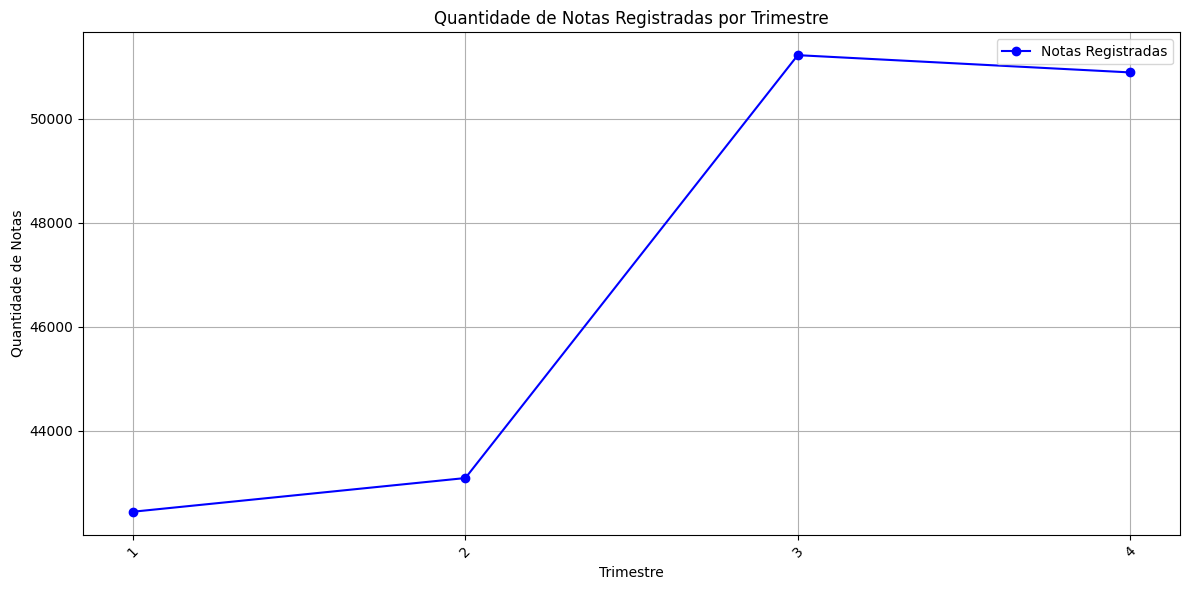

In [6]:
# Quantidade de notas registradas por trimestre
notas_por_trimestre = df.groupby('trimestre').size().reset_index(name='Quantidade_Notas')

# Plotando a quantidade de notas por trimestre
plt.figure(figsize=(12, 6))
plt.plot(notas_por_trimestre['trimestre'].astype(str), notas_por_trimestre['Quantidade_Notas'], marker='o', color='b', label='Notas Registradas')
plt.title('Quantidade de Notas Registradas por Trimestre')

# Configuração gráfica
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

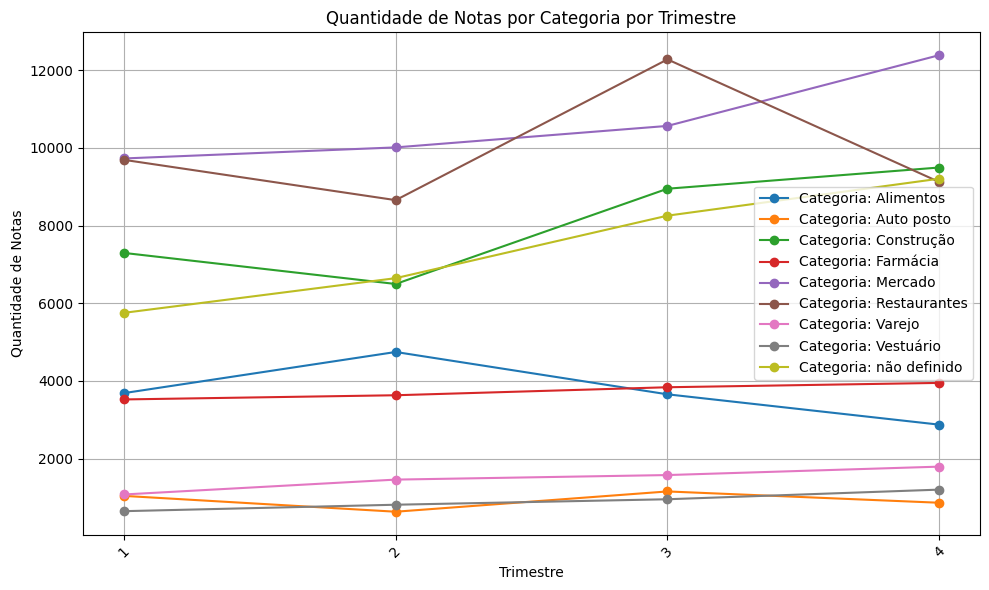

In [7]:
# Quantidade de notas por categoria por trimestre
notas_por_categoria_trimestre = df.groupby(['trimestre', 'categoria']).size().reset_index(name='Quantidade_Notas_Categoria')

# Plotando a quantidade de notas por categoria por trimestre
plt.figure(figsize=(10, 6))
for categoria in notas_por_categoria_trimestre['categoria'].unique():
    categoria_data = notas_por_categoria_trimestre[notas_por_categoria_trimestre['categoria'] == categoria]
    plt.plot(categoria_data['trimestre'].astype(str), categoria_data['Quantidade_Notas_Categoria'], marker='o', label=f'Categoria: {categoria}')

#Configuração Gráfica
plt.title('Quantidade de Notas por Categoria por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


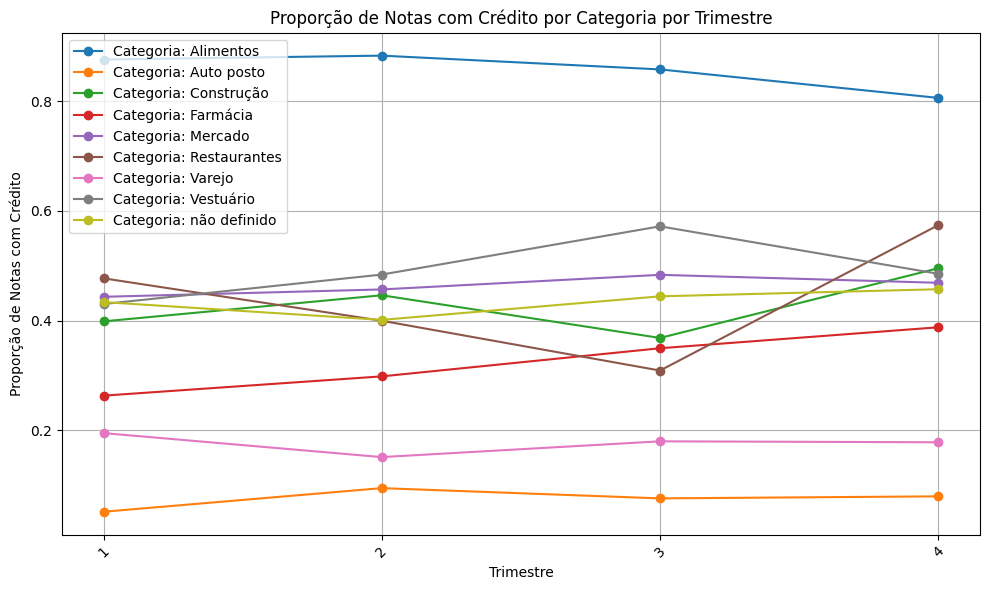

In [8]:
# Proporção de notas com crédito por categoria por trimestre
df['nota_com_credito'] = df['flag_credito'] == 1
proporcao_credito_categoria_trimestre = df.groupby(['trimestre', 'categoria'])['nota_com_credito'].mean().reset_index(name='Proporcao_Credito')

# Plotando a proporção de notas com crédito por categoria por trimestre
plt.figure(figsize=(10, 6))
for categoria in proporcao_credito_categoria_trimestre['categoria'].unique():
    categoria_data = proporcao_credito_categoria_trimestre[proporcao_credito_categoria_trimestre['categoria'] == categoria]
    plt.plot(categoria_data['trimestre'].astype(str), categoria_data['Proporcao_Credito'], marker='o', label=f'Categoria: {categoria}')

# Configuração gráfica
plt.title('Proporção de Notas com Crédito por Categoria por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [9]:
# Função para calcular WOE e IV

def calc_woe_iv(df):
    woe_iv = []

    # Eventos e não eventos
    total_eventos = df['flag_credito'].sum()
    total_nao_eventos = len(df) - total_eventos

    # Agrupar por categoria
    for categoria in df['categoria'].unique():
        df_categoria = df[df['categoria'] == categoria]
        
        eventos = df_categoria['flag_credito'].sum()
        nao_eventos = len(df_categoria) - eventos

        # Calcular proporções
        pct_eventos = eventos / total_eventos if total_eventos > 0 else 0
        pct_nao_eventos = nao_eventos / total_nao_eventos if total_nao_eventos > 0 else 0

        # Calcular WOE e IV
        woe = np.log(pct_eventos / pct_nao_eventos) if pct_nao_eventos > 0 else np.nan
        iv = (pct_eventos - pct_nao_eventos) * woe if not np.isnan(woe) else 0

        # Armazenar os resultados
        woe_iv.append({
            'categoria': categoria,
            'WOE': woe,
            'IV': iv
        })
    
    # Calcular o IV total
    iv_total = sum([x['IV'] for x in woe_iv])
    
    # Converter para DataFrame
    woe_iv_df = pd.DataFrame(woe_iv)
    
    return woe_iv_df, iv_total

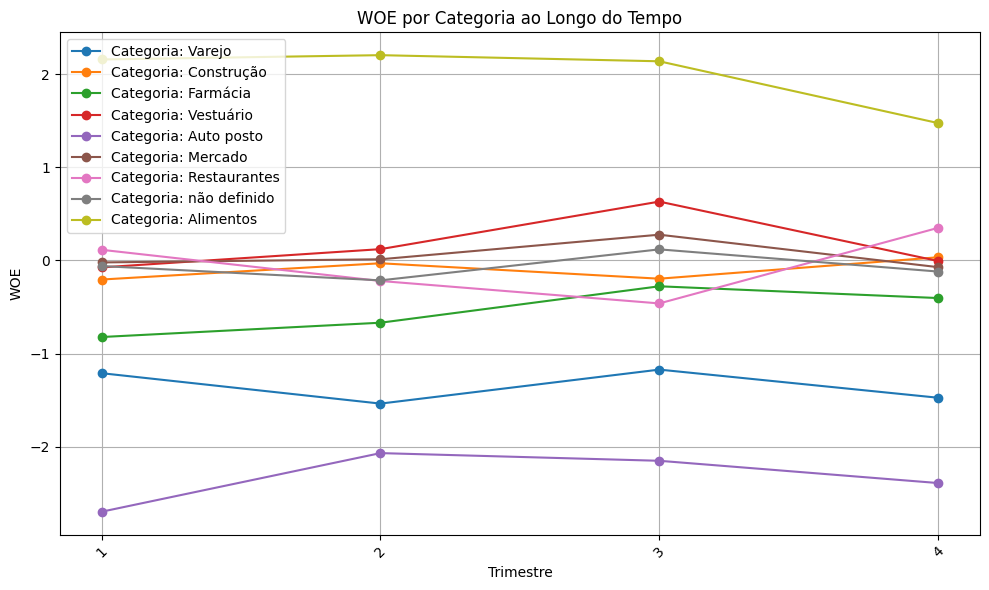

In [10]:
woe_iv_por_trimestre = []

# Calc Woe e Vif por trimestre
for trimestre in df['trimestre'].unique():
    df_trimestre = df[df['trimestre'] == trimestre]
    woe_iv, iv_total = calc_woe_iv(df_trimestre)
    woe_iv['Trimestre'] = trimestre
    woe_iv['IV_Total'] = iv_total
    woe_iv_por_trimestre.append(woe_iv)

# Unir os resultados de todos os trimestres
woe_iv_temporal = pd.concat(woe_iv_por_trimestre)

# Ordernar por trimestres na ordem correta (1 2 3 4)
woe_iv_temporal['Trimestre'] = pd.to_numeric(woe_iv_temporal['Trimestre'], errors='coerce')
woe_iv_temporal = woe_iv_temporal.sort_values('Trimestre')

# Gráfico
plt.figure(figsize=(10, 6))
for categoria in woe_iv_temporal['categoria'].unique():
    categoria_data = woe_iv_temporal[woe_iv_temporal['categoria'] == categoria]
    plt.plot(categoria_data['Trimestre'].astype(str), categoria_data['WOE'], marker='o', label=f'Categoria: {categoria}')

# Configuração Gráfica
plt.title('WOE por Categoria ao Longo do Tempo')
plt.xlabel('Trimestre')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

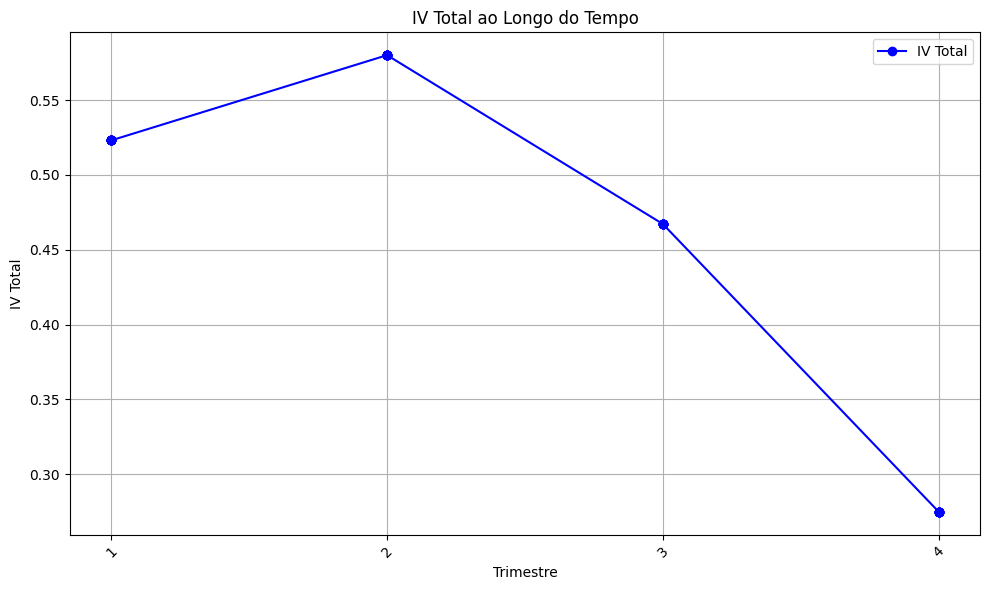

In [11]:
# Plotando o IV Total por Trimestre
plt.figure(figsize=(10, 6))
plt.plot(woe_iv_temporal['Trimestre'].astype(str), woe_iv_temporal['IV_Total'], marker='o', color='b', label='IV Total')

plt.title('IV Total ao Longo do Tempo')
plt.xlabel('Trimestre')
plt.ylabel('IV Total')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [12]:
# Calcular o IV por trimestre e categoria
iv_por_trimestre_categoria = []

for trimestre in df['trimestre'].unique():
    
    df_trimestre = df[df['trimestre'] == trimestre]
    
    # Iv para cada categoria
    grupo = df_trimestre.groupby('categoria').agg(
        eventos=('flag_credito', 'sum'),  
        total=('flag_credito', 'count')   
    ).reset_index()

    grupo['nao_eventos'] = grupo['total'] - grupo['eventos']

    # Totais gerais
    total_eventos = grupo['eventos'].sum()
    total_nao_eventos = grupo['nao_eventos'].sum()

    # Woe
    grupo['pct_eventos'] = grupo['eventos'] / total_eventos
    grupo['pct_nao_eventos'] = grupo['nao_eventos'] / total_nao_eventos
    grupo['WOE'] = np.log(grupo['pct_eventos'] / grupo['pct_nao_eventos'])


    # Vif
    grupo['IV'] = (grupo['pct_eventos'] - grupo['pct_nao_eventos']) * grupo['WOE']
    IV_total = grupo['IV'].sum()

    # Trimestre
    grupo['Trimestre'] = trimestre
    grupo['IV_Total'] = IV_total

    iv_por_trimestre_categoria.append(grupo[['categoria', 'Trimestre', 'IV', 'IV_Total']])

# Unindo resultados
iv_temporal_por_categoria = pd.concat(iv_por_trimestre_categoria)

# Pivot
iv_temporal_pivot = iv_temporal_por_categoria.pivot(index='Trimestre', columns='categoria', values='IV')

# Iv total
iv_temporal_pivot['IV_Total'] = iv_temporal_por_categoria.groupby('Trimestre')['IV_Total'].first()

# Exibindo a tabela
iv_temporal_pivot

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido,IV_Total
Trimestre,,,,,,,,,,
1,0.323704,0.106063,0.007110,0.051118,0.000102,0.003013,0.031457,8.393046e-05,0.000487,0.523138
2,0.420410,0.043929,0.000136,0.035271,0.000039,0.009608,0.063478,2.799806e-04,0.006953,0.580105
3,0.278258,0.067653,0.006564,0.005595,0.016088,0.048278,0.034897,7.593978e-03,0.002310,0.467236
4,0.106368,0.066041,0.000221,0.012411,0.001256,0.021891,0.064139,8.556843e-07,0.002559,0.274886


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

* Maior proporção de notas com retornos maiores que 0: <br><br>
    * <span style="color: brown;">**Mercado**</span> se mantém como o maior numero de notas com retornos maiores que zero por quase todo o ano.
    * Exceto que, no terceiro trimestre os <span style="color: pink;">**Restaurantes**</span>,  parecem possuir um numero maior de notas.
    * Contudo,
<span style="color: brown;">**Mercados**</span> e <span style="color: pink;">**Restaurantes**</span>,  possuem um **Vif** peequeníssimo, não ajudando a explicar as demais variaveis e não possuindo colinearidade.
    * <span style="color: yellow;">**Alimentos**</span> é a unica categoria que mantém um **Woe** e um **Vif** poderoso durante todos os **trimestres**.
<br><br>
* As variaveis apresentam um certo nivel de estabilidade de **Woe** e **Vif** durante os diferentes trimestres
  * Contudo, apresentam uma grande variança quando se trata de sua proporção de emissão de notas conforme o trimestre.